In [179]:
#from util import *
import os, shutil
import pandas as pd

from opmap.videoData import VideoData
from opmap.vmemMap import VmemMap
from opmap.phaseMap import PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap
from elecpy.elecpySession import ElecpySession


In [180]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from matplotlib import cm
import copy

%matplotlib inline

In [181]:
src_dir = '/mnt/recordings/SimulationResult/'
save_dir = '/mnt/recordings/AnalysisResult/Tomii/2018-09-07/'
print(save_dir)
if not os.path.exists(save_dir) : os.mkdir(save_dir)

/mnt/recordings/AnalysisResult/Tomii/2018-09-07/


In [182]:

def phaseComplement(value):
    value -= (value > np.pi)*2*np.pi
    value += (value < - np.pi)*2*np.pi
    return value


In [183]:
def analyzeSession(sess, save_dir=None):
    cam = VideoData(*sess.data['vmem'].shape)
    cam.data = - sess.data['vmem']
    v = VmemMap(cam);del(cam)
    p = PhaseMap(v, width = v.data.shape[2]); 
    p.data = - p.data
    pv = PhaseVarianceMap(p, size=3)
    
    if save_dir is not None:
        v.saveImage( os.path.join(save_dir, 'vmem'))
        p.saveImage( os.path.join(save_dir, 'pmap'))
        pv.saveImage( os.path.join(save_dir, 'pvmap'))

    sess.data['phase'] = p.data
    sess.data['pv'] = pv.data

In [184]:
def plot_phase_surface(sess, frame, cut_thre = 2*np.pi*0.75, angle=0):
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim3d(-np.pi, np.pi)

    _, size_h, size_w = sess.data['phase'].shape

    y = np.arange(size_h)
    x = np.arange(size_w)
    X, Y = np.meshgrid(x, y)
    Z = sess.data['phase'][frame, ::-1, :]
    
    if angle is 1: Z = Z.T[:,::-1]
    if angle is 2: Z = Z[::-1,::-1]
    if angle is 3: Z = Z.T[::-1,:]

    wire = ax.plot_wireframe(X, Y, Z)

    nx, ny, _  = np.shape(wire._segments3d)
    wire_x = np.array(wire._segments3d)[:, :, 0].ravel()
    wire_y = np.array(wire._segments3d)[:, :, 1].ravel()
    wire_z = np.array(wire._segments3d)[:, :, 2].ravel()
    wire.remove()

    # create data for a LineCollection
    wire_x1 = np.vstack([wire_x, np.roll(wire_x, 1)])
    wire_y1 = np.vstack([wire_y, np.roll(wire_y, 1)])
    wire_z1 = np.vstack([wire_z, np.roll(wire_z, 1)])

    to_delete = np.arange(0, nx*ny, ny)
    wire_x1 = np.delete(wire_x1, to_delete, axis=1)
    wire_y1 = np.delete(wire_y1, to_delete, axis=1)
    wire_z1 = np.delete(wire_z1, to_delete, axis=1)
    scalars = np.delete(wire_z, to_delete)

    segs = np.array([list(zip(xl, yl, zl)) for xl, yl, zl in \
                 zip(wire_x1.T, wire_y1.T, wire_z1.T)])

    # delete false phase discontinuity
    to_delete = np.where( np.array([ abs( seg[0][2] - seg[1][2]) for seg in segs ]) > cut_thre)[0]
    segs = np.delete( segs, to_delete, axis=0)
    scalars = np.delete( scalars, to_delete)

    # Plots the wireframe by a  a line3DCollection
    my_wire = art3d.Line3DCollection(segs, cmap="jet")
    my_wire.set_array(scalars)
    my_wire.set_clim(vmin=-np.pi, vmax=np.pi)
    ax.add_collection(my_wire)

    plt.colorbar(my_wire)



## Check whole dynamics

In [143]:
df = pd.read_csv('data.whole.csv')
df

,sim_id,description
0,20180907-2,S1(ext -50)
1,20180907-3,S1(ext -50)
2,20180907-4,S1(mem 10)


/mnt/recordings/AnalysisResult/Tomii/2018-09-07/20180907-3
('phie', 101, 101)


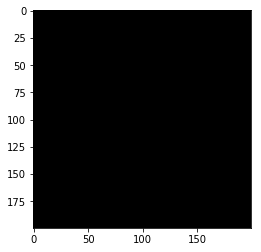

In [149]:

for i, row in df.iterrows():
    
    if i not in [1]: continue
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)
        
    sess = ElecpySession( os.path.join(src_dir, row.sim_id), keys=['vmem', "phie"])
    
    analyzeSession(sess, save_dir=dst_dir)
    
    plt.imshow(np.sum(sess.data['pv'][100:-100,:,:] > 0.3, axis=0), cmap='gray')
    plt.savefig(os.path.join(dst_dir, 'traj.png'))
    

## Check region detail

In [188]:
df = pd.read_csv('data.roi.csv')
df

,sim_id,x_min,x_max,y_min,y_max,f_min,f_max,result_id,description
0,20180525-1,135,165,85,115,290,330,-,control
1,20180823-1,80,120,80,120,105,175,A,pinning
2,20180625-1,110,150,80,120,120,160,C,meandering
3,20180625-1,160,200,80,120,220,260,D,spiral stop
4,20180616-1,80,120,80,120,360,400,B,over the trajectory of vortex shedding


In [186]:
thre_phase_integ = np.pi*0.5

In [ ]:
for i, row in df.iterrows():
    
    #if i not in [5]: continue
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    dst_dir = os.path.join(dst_dir, 'x{0}-{1}_y{2}-{3}_f{4}-{5}'.format(
        row.x_min,row.x_max,
        row.y_min,row.y_max,
        row.f_min,row.f_max,
    ))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)
        
    
    sess = ElecpySession("/mnt/recordings/SimulationResult/"+row.sim_id, keys=['vmem', 'cell/xina'])
    sess.setRange(
        x_min = row.x_min,
        x_max = row.x_max,
        y_min = row.y_min,
        y_max = row.y_max
    )
    
    analyzeSession(sess, save_dir=dst_dir)
    sess.setRange(
        f_min = row.f_min,
        f_max = row.f_max,
    )

    p = sess.data['phase']
    
    ### Vmem(raw) ###
    if False:
        path = os.path.join(dst_dir,'vmem_raw')
        if not os.path.exists(path) : os.mkdir(path)
        vmin = sess.data['vmem'].min()
        vmax = sess.data['vmem'].max()
        for f, vmem in enumerate(sess.data['vmem']):
            plt.imsave(os.path.join(path, '{0:0>4}.png'.format(f)), vmem, cmap='gray', vmin=vmin, vmax=vmax)
    
    
    ### 3D phase plot ###
    for angle in range(4):

        path = os.path.join(dst_dir,'psurf_{0}'.format(angle))
        if not os.path.exists(path) : os.mkdir(path)

        for frame in range(row.f_max-row.f_min):

            plt.clf()
            plot_phase_surface(sess, frame, angle=angle)
            plt.savefig(os.path.join(path, '{0:0>6}.png'.format(frame)))
    continue

    ### integral of time differential ###
    p = sess.data['phase']
    pdiff = copy.deepcopy(p)
    for f in range(len(pdiff)):
        if f == 0: 
            pdiff[f,:,:] = 0
        else:
            pdiff[f,:,:] = p[f,:,:] - p[f-1,:,:]
    pdiff = phaseComplement(pdiff)
    pinteg = abs(np.sum(pdiff, axis=0))
    
    plt.clf()
    plt.imshow(pinteg, vmin=0, cmap='gray') # vmax=2*np.pi, 
    plt.colorbar()
    plt.savefig(os.path.join(dst_dir, 'pinteg.png'))
    
    ### phase graph (time sequence) ###
    pos_y, pos_x = np.where(pinteg > thre_phase_integ)
    neg_y, neg_x = np.where(pinteg <= thre_phase_integ)
    plt.clf()
    plt.subplot(2,1,1)
    for y, x in zip(neg_y, neg_x):
        if x == p.shape[2]//2:
            plt.plot(p[:,y,x], 'b')
    plt.subplot(2,1,2)
    for y, x in zip(pos_y, pos_x):
        if x == p.shape[2]//2:
            plt.plot(p[:,y,x], 'r')
    plt.savefig(os.path.join(dst_dir, 'border_plot.png'))
    plt.close()

    
    ### phase graph (circular plot) ###
    path = os.path.join(dst_dir,'border_plot')
    if not os.path.exists(path) : os.mkdir(path)
    for f in range(len(p)):

        plt.figure(figsize=(5,5))
        plt.clf()

        phases = np.arange(0,2*np.pi,np.pi/1024)
        plt.scatter( np.cos(phases), np.sin(phases), c='k', s=.02)
        
        A = np.arange(-1.2, 1.2, 0.01)
        plt.scatter( A, np.zeros_like(A), c='k', s=.02)
        plt.scatter( np.zeros_like(A), A, c='k', s=.02)

        pos_y, pos_x = np.where(pinteg > thre_phase_integ)
        for y, x in zip(pos_y, pos_x):
            if x == p.shape[2]//2:
                phases = p[f,y,x]
                plt.scatter( np.cos(phases), np.sin(phases), c='r', s=10)

        neg_y, neg_x = np.where(pinteg <= thre_phase_integ)
        for y, x in zip(neg_y, neg_x):
            if x == p.shape[2]//2:
                phases = p[f,y,x]
                plt.scatter( np.cos(phases), np.sin(phases), c='b', s=10)

        plt.axis('equal')
        plt.axis([-1.2, 1.2, -1.2, 1.2])
        plt.savefig(os.path.join(path, '{0:0>6}.png'.format(f)))
        plt.close()

    ### spatial phase differential ###
    path = os.path.join(dst_dir,'pdiff_xy')
    if not os.path.exists(path) : os.mkdir(path)
    for f in range(len(p)):
        
        pdiff_x = np.zeros_like(p[f,:,:], dtype=np.int)
        pdiff_x[0,:] = 0
        pdiff_x[1:,:] = ( np.abs( phaseComplement(p[f,1:,:] - p[f,:-1,:]) ) > (np.pi*2/4)) * 1
        pdiff_y = np.zeros_like(p[f,:,:], dtype=np.int)
        pdiff_y[:,0] = 0
        pdiff_y[:,1:] = ( np.abs( phaseComplement(p[f,:,1:] - p[f,:,:-1]) ) > (np.pi*2/4)) * 1
        
        pdiff_xy = pdiff_x+pdiff_y
        
        plt.clf()
        plt.imshow(pdiff_xy, vmin=0, vmax=2, cmap='gray')
        plt.savefig(os.path.join(path, '{0:0>6}.png'.format(f)))
        plt.close()
        
        
    ### Sodium current integral ###
    
#     xina = abs(np.sum(sess.data["cell/xina"], axis=0))
#     plt.clf()
#     plt.imshow(xina, cmap='gray')
#     plt.colorbar()
#     plt.savefig(os.path.join(dst_dir, 'xina.png'))
    
    plt.clf()
    plt.imshow(np.sum(sess.data['pv'] > 0.6, axis=0)>0, cmap='gray')
    plt.colorbar()
    plt.savefig(os.path.join(dst_dir, 'traj.png'))
    